In [1]:
!pip install pandas scikit-learn gensim matplotlib

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import gensim
%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
data = pd.read_csv('/gdrive/My Drive/quora/train.csv')

In [5]:
data.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [0]:
vocab = Counter()

for text in data.question_text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

273056

In [0]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

48010

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:
X = []

for text in data.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MAX_LEN = max(len(x) for x in X)
MAX_LEN

134

In [0]:
MAX_LEN = 100

In [16]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(1306122, 100)

In [0]:
y = data.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

### Задание 1
а) Конкатенация эмбедингов в один большой

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(word2id), input_length=MAX_LEN, output_dim=100))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=10)

Epoch 1/10
311/311 [==============================] - 70s 224ms/step - loss: 0.0303 - root_mean_squared_error: 0.1742 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1925
Epoch 2/10
311/311 [==============================] - 67s 216ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1933
Epoch 3/10
311/311 [==============================] - 67s 215ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1947
Epoch 4/10
311/311 [==============================] - 67s 214ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1961
Epoch 5/10
311/311 [==============================] - 67s 217ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1980
Epoch 6/10
311/311 [==============================] - 67s 216ms/step - loss: 0.0245 - root_mean_squared_error: 0.1564 - val_l

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


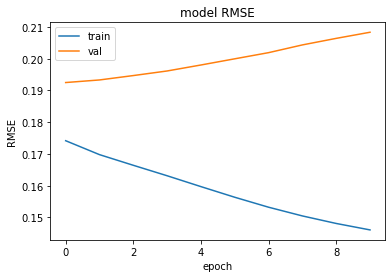

In [0]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

б) Усреднение эмбедингов

In [0]:
inputs = tf.keras.layers.Input(shape=(100,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [0]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=10)

Epoch 1/10
311/311 [==============================] - 62s 199ms/step - loss: 0.1821 - root_mean_squared_error: 0.4270 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3354
Epoch 2/10
311/311 [==============================] - 62s 200ms/step - loss: 0.0788 - root_mean_squared_error: 0.2808 - val_loss: 0.0611 - val_root_mean_squared_error: 0.2471
Epoch 3/10
311/311 [==============================] - 64s 205ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.0562 - val_root_mean_squared_error: 0.2372
Epoch 4/10
311/311 [==============================] - 63s 204ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.0554 - val_root_mean_squared_error: 0.2354
Epoch 5/10
311/311 [==============================] - 63s 204ms/step - loss: 0.0566 - root_mean_squared_error: 0.2378 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2345
Epoch 6/10
311/311 [==============================] - 63s 202ms/step - loss: 0.0562 - root_mean_squared_error: 0.2370 - val_l

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


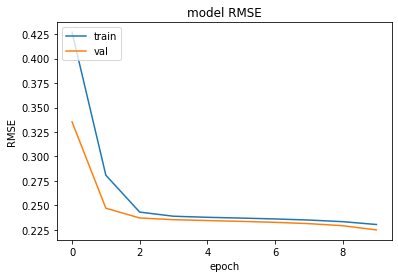

In [0]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

в) Складывание эмбедингов

In [0]:
inputs = tf.keras.layers.Input(shape=(100,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
sum = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(sum)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [0]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=10)

Epoch 1/10
311/311 [==============================] - 55s 177ms/step - loss: 0.0566 - root_mean_squared_error: 0.2381 - val_loss: 0.0456 - val_root_mean_squared_error: 0.2135
Epoch 2/10
311/311 [==============================] - 55s 176ms/step - loss: 0.0416 - root_mean_squared_error: 0.2039 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 3/10
311/311 [==============================] - 55s 176ms/step - loss: 0.0364 - root_mean_squared_error: 0.1909 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 4/10
311/311 [==============================] - 58s 187ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1832
Epoch 5/10
311/311 [==============================] - 55s 178ms/step - loss: 0.0329 - root_mean_squared_error: 0.1815 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814
Epoch 6/10
311/311 [==============================] - 56s 180ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - val_l

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


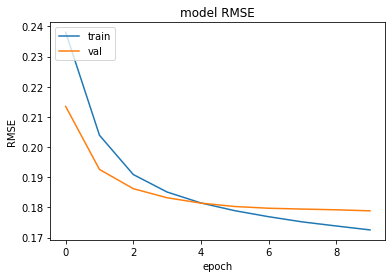

In [0]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Задание 2 

In [0]:
from tqdm import tqdm

In [26]:
w2v = gensim.models.Word2Vec([text.split() for text in tqdm(data['question_text'])], size=100, sg=1)

100%|██████████| 1306122/1306122 [00:05<00:00, 229268.54it/s]


In [0]:
embedding_matrix1 = np.zeros((len(w2v.wv.vocab) + 1, 100))
for i, vec in enumerate(w2v.wv.vectors):
  embedding_matrix[i] = vec

In [37]:
fasttxt = gensim.models.FastText([text.split() for text in tqdm(data['question_text'])], size=100, sg=1)

100%|██████████| 1306122/1306122 [00:06<00:00, 191633.73it/s]


In [0]:
embedding_matrix2 = np.zeros((len(fasttxt.wv.vocab) + 1, 100))
for i, vec in enumerate(fasttxt.wv.vectors):
  embedding_matrix2[i] = vec

In [0]:
inputs = tf.keras.layers.Input(shape=(100,))
embedding1 = tf.keras.layers.Embedding(input_dim=len(w2v.wv.vocab)+1, output_dim=100, weights=[embedding_matrix1])(inputs)
embedding2 = tf.keras.layers.Embedding(input_dim=len(fasttxt.wv.vocab)+1, output_dim=100, weights=[embedding_matrix2])(inputs)
embeddings = tf.keras.layers.concatenate([embedding1, embedding2])
sum = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(sum)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [0]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [45]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=7000,
         epochs=10)

Epoch 1/10
178/178 [==============================] - 124s 694ms/step - loss: 0.0451 - root_mean_squared_error: 0.2122 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1970
Epoch 2/10
178/178 [==============================] - 123s 691ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 3/10
178/178 [==============================] - 124s 696ms/step - loss: 0.0346 - root_mean_squared_error: 0.1859 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1841
Epoch 4/10
178/178 [==============================] - 124s 694ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1822
Epoch 5/10
178/178 [==============================] - 125s 701ms/step - loss: 0.0322 - root_mean_squared_error: 0.1793 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1815
Epoch 6/10
178/178 [==============================] - 125s 700ms/step - loss: 0.0315 - root_mean_squared_error: 0.1775 -

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


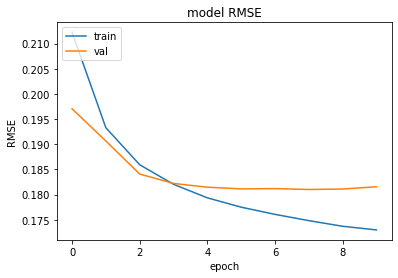

In [46]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()